In [1]:
%matplotlib inline

from os.path import join
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors as mat_colors
from scipy.stats import gaussian_kde


# Project specific module/functions
from healthy_candies.load import load_clean_rel_to_nutri, NUTRI_COLS
from healthy_candies.load.schema import SCHEMA
from healthy_candies.utils import show_colors, plot_settings
from healthy_candies.path import STATIC_DATA_FOLDER, EXPORT_FOLDER

In [2]:
# Plot settings
sns.set()  # Use default seaborn styling for all plots
sns.set_context('notebook')
plt.rcParams['figure.dpi'] = 100

In [3]:
# Ploty related scripts to handle the many exports for data story
# The plotly related code is bit uggly, sorry about that.
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)


def to_plotly_col(rgb: tuple) -> str:
    """
    Converts a tuple (r, g, b) to a string compatible with css format.
    
    r, g & b are expected to fall in [0, 1]
    """
    return "rgb({r}, {g}, {b})".format(
        r=int(rgb[0] * 255),
        g=int(rgb[1] * 255),
        b=int(rgb[2] * 255))


def get_plotly_layout(title: str='', xlabel: str='', ylabel: str='') -> go.Layout:
    """
    Function to get a generic plotly layout
    """
    font_family = '"Merriweather", serif'
    return go.Layout(
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)',
        font=dict(
            family=font_family,
            size=18,
            color='#595959'),
        hoverlabel=dict(
            font=dict(family=font_family)),
        title='<b>{}</b>'.format(title),
        xaxis=dict(
            title=xlabel),
        yaxis=dict(
            title=ylabel)
    )


def plotly_plot(fig: go.Figure, fn: str):
    """
    Renders a ploty figure (`fig`) in an html file at location `fn`.
    """
    plot(fig,
         filename=fn,
         include_plotlyjs='cdn',
         include_mathjax='cdn',
         show_link=False)

In [4]:
# General constant
N_BOOTSTRAP = 500
N_KDE_STEPS = 200

# Packaging colours

In [5]:
COLORS_FILE = join(STATIC_DATA_FOLDER, 'colors.csv.zip')

## Introduction

Alongside various nutritional information available in the *Open Food Facts* database, we can often find an image associated with each product. Those images are pictures of the packagings of the products taken by the contributors using the smartphone app. Here is a simple example taken from the dataset:

![Image OFF](https://static.openfoodfacts.org/images/products/356/007/061/7593/front_fr.7.400.jpg)

Being a little bit familiar with colour theory and having been exposed to the known impact of colour on consumers (for example in the article [*Impact of colour on marketing*](https://www.emeraldinsight.com/doi/abs/10.1108/00251740610673332)), we found in this dataset the opportunity to quantify the use of colour in the food industry.

From the previous article, we learn for example that:
- "The red colour stimulates appetite because of its effect on our metabolism",
- "The yellow colour is also employed \[to\] gain customers’ attention, increase their appetite, and encourage them to eat",
- blue is more used to calm and relax,

We also know that green is associated with a feeling of freshness and that there has been a lot of attention drawn on that colour recently under the term "greenwashing" which summarizes the idea of using green to impact the perception of not-healthy products.


As said earlier, in this part of the project we focus on quantifying the use of colours on packagings; we also investigate the ties between colours and nutrition facts.


Before diving into our results, we need to address some remarks regarding colour theory.



### Principle

Since often when looking at products packagings our eyes are attracted by the different colours that appear on it, we decided to focus on the **hue** information contained in each pixel of the image.

The hue is a colour component that characterizes the dominant wavelength associated with a colour. As we can see on the image below, there are 6 main hues:

* red,
* yellow,
* green,
* cyan,
* blue,
* magenta.


![Hues](https://upload.wikimedia.org/wikipedia/commons/thumb/a/ad/HueScale.svg/1024px-HueScale.svg.png)


To catch a bit more information from the data, we will actually focus on a 12-hue variant of that scale by adding intermediary hue points. The final hues we worked with are visible below.

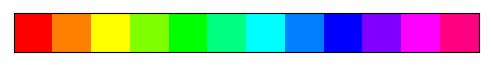

In [6]:
HUES_STR = ['red', 'orange', 'yellow', 'yellow-green', 'green', 'green-cyan',
            'cyan', 'cyan-blue', 'blue', 'blue-magenta', 'magenta', 'pink']

HUES_RGB = [(1, 0, 0),
            (1, 0.5, 0),
            (1, 1, 0),
            (0.5, 1, 0),
            (0, 1, 0),
            (0, 1, 0.5),
            (0, 1, 1),
            (0, 0.5, 1),
            (0, 0, 1),
            (0.5, 0, 1),
            (1, 0, 1),
            (1, 0, 0.5)]

HUES = {hue: rgb for hue, rgb in zip(HUES_STR, HUES_RGB)}
show_colors(HUES_RGB)
plt.show()

As you certainly know, a colour cannot be simplified solely to its hue value. In fact, there exist multiple colour decomposition to work with colour and hues. The one we used is *HSV*, which stands for: *Hue, Saturation & Value*.

![HSV triangle](https://upload.wikimedia.org/wikipedia/commons/1/1b/Triangulo_HSV.png)

We have already talked about hue, but saturation and value are two very important components as they impact other aspects of each colour. For instance, we can see below that very dark colours still have a relevant hue value.

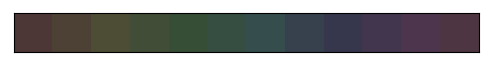

In [7]:
N_HUES = 12

ref_hues = list(np.linspace(0, 1, N_HUES+1))
cols = [mat_colors.hsv_to_rgb([h, 0.3, 0.3]) for h in ref_hues][:-1]
show_colors(cols)
plt.show()

But such colours are too dark to really catch the consumer attention. That's why, when extracting the hues of the images we kept track only of pixels that have a minimum *saturation* and *value*, according to the threshold depicted below.

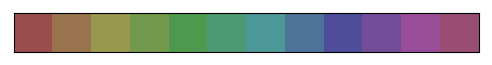

In [8]:
cols = [mat_colors.hsv_to_rgb([h, 0.5, 0.6]) for h in ref_hues][:-1]
show_colors(cols)
plt.show()

That being said, we scripted the [scraping of all the available images](https://github.com/striantafyllouEPFL/healthy-candies/blob/master/healthy_candies/scrap_images.py) and the [extraction of the hues](https://github.com/striantafyllouEPFL/healthy-candies/blob/master/static_data/scripts/extract_colors.py) present in each image. To put that last process in few words, we associated each valid pixel (a pixel which value and saturation is high enough) to the closest of the 12 hues. It has to be noted that here we make the assumption that the hues inside the pictures haven't been tweaked (the user hasn't played with the white balance of its picture); considering the many product images we have seen, this seems like a very acceptable hypothesis as we haven't encountered a counterexample and the images are generally well exposed.

At the end, for each product that has an image, we get the number of pixels that matched each hue, as we can see below.

In [9]:
def get_colors_df() -> pd.DataFrame:
    """
    Returns the df with data related to colors
    """
    df = pd.read_csv(COLORS_FILE, dtype={'code': str})
    return sort_colors_col(df)


def sort_colors_col(df: pd.DataFrame) -> pd.DataFrame:
    """
        Simple function to sort the columns
        in hue logic
    """
    out = df.copy()
    for col in HUES_STR:
        out = out.drop(col, axis=1)
        out[col] = df[col]
    return out


colors = get_colors_df()
colors.head()

,code,total_pix,total_valid_pix,red,orange,yellow,yellow-green,green,green-cyan,cyan,cyan-blue,blue,blue-magenta,magenta,pink
0,0000007020254,30000,611,484,127,0,0,0,0,0,0,0,0,0,0
1,0000027533024,26800,929,219,708,2,0,0,0,0,0,0,0,0,0
2,0000027533048,28200,153,100,51,2,0,0,0,0,0,0,0,0,0
3,0000040608754,20200,6955,1457,0,138,0,0,0,110,4014,1222,0,0,14
4,0000087177756,20000,1445,61,188,553,195,4,252,186,6,0,0,0,0


Finally, we get a clear idea of what hues are present on each packaging and in what amount.



---


*We can then move on to the results we found.*


N.B. : in the following sections, we considered only products that had (a product image and) *cleaned* nutri-facts according to the process described in [this notebook](https://github.com/striantafyllouEPFL/healthy-candies/blob/master/notebooks/clean_data_relative_to_nutrifacts.ipynb). This enables to be a bit more confident in the data we use since *Open Food Facts* is a community built database.

## RQ | Global representation of colours on packagings

As explained in the introduction, different colours have different perceptual impact on the consumers. Having this in mind, we were interested in looking at what colours are *dominant* on the product’s pictures.

To achieve a robust estimate of the dominant colour (/hue) on each picture, we rank all the hues for each product and then look at the distribution of hues at rank $1$, $2$, etc.

So first we convert the previous dataframe to get for each row and hue, the rank of the hue among all hues (i.e. what is the $i^{th}$ dominant hue on the packaging).

In [10]:
colors_only = colors.drop(['total_pix', 'total_valid_pix', 'code'], axis=1)
colors_ranks = colors_only.replace(0, np.nan) \
    .rank(method='min', axis=1, ascending=False, na_option='keep')
colors_ranks.head()
# Nan: we don't have any information (some hues are absent from some packagings)

,red,orange,yellow,yellow-green,green,green-cyan,cyan,cyan-blue,blue,blue-magenta,magenta,pink
0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,2.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.0,NaN,4.0,NaN,NaN,NaN,5.0,1.0,3.0,NaN,NaN,6.0
4,6.0,4.0,1.0,3.0,8.0,2.0,5.0,7.0,NaN,NaN,NaN,NaN


After having prepared the data, we can look at the distribution of hues at each rank. Here we will look only at the first three ones since we can assume that they are the ones that are most likely to attract the consumers' eyes. 

In [11]:
# A little bit of bootstrap to get confidence intervals
# Especially usefull as i => 12


def bootstrap_color_prop(rank_df: pd.DataFrame, i: int = 1) -> pd.DataFrame:
    """
    Function to run a bootstrap analysis on the color proportion
    """
    colors = list(rank_df.columns)
    out = {hue: {j: list() for j in range(1, i+1)} for hue in colors}

    for n in range(N_BOOTSTRAP):
        sample = rank_df.sample(frac=1, replace=True)
        for j in range(1, i+1):
            df = (sample == j).sum(axis=0)
            df /= df.sum()
            for col in colors:
                out[col][j].append(df[col])

    return out

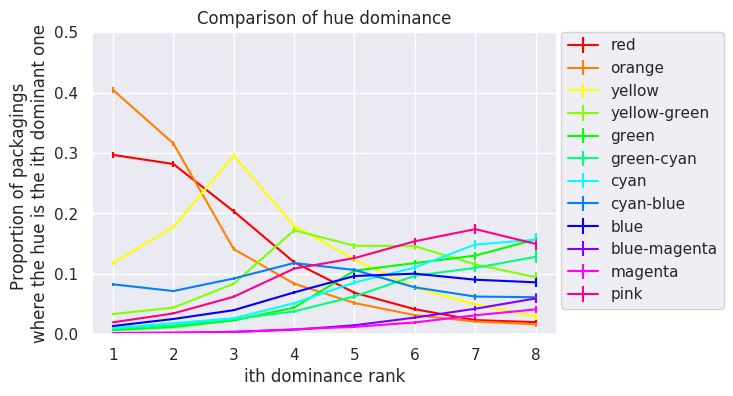

In [12]:
values = bootstrap_color_prop(colors_ranks, 8)

# Plotting all the curves
for hue, hue_rgb in zip(HUES_STR, HUES_RGB):
    vals = pd.DataFrame.from_dict(values[hue])
    medians = vals.median()
    yerr = vals.quantile([0.025, 0.975]) - medians
    ax = medians.plot(
        ylim=(0, 0.5),
        yerr=yerr.values,
        color=hue_rgb,
        label=hue)
    ax.legend()

plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plot_settings({
    'title': 'Comparison of hue dominance',
    'xlabel': 'ith dominance rank',
    'ylabel': 'Proportion of packagings \n'
              'where the hue is the ith dominant one'})

In [13]:
# Export with plotly for data story
# Same kind of logic as above
# Rounding is used to optimize file size.

data = []

for hue, hue_rgb in zip(HUES_STR, HUES_RGB):
    vals = pd.DataFrame.from_dict(values[hue]) * 100
    medians = vals.median().round(2)
    yerr = vals.quantile([0.025, 0.975]).round(2)
    data.append(go.Scatter(
        x=medians.index,
        y=medians,
        text='',
        name=hue,
        line=dict(color=to_plotly_col(hue_rgb)),
        error_y=dict(
            type='data',
            symmetric=False,
            array=medians - yerr.iloc[1, :],
            arrayminus=yerr.iloc[0, :] - medians,
            color=to_plotly_col(hue_rgb)
        )
    ))

layout = get_plotly_layout(
    title='Comparaison of hue dominance',
    xlabel='$i^{th} \\text{ dominance rank}$',
    ylabel='$\\text{Proportion of packagings '
           'where the hue is the } i^{th} \\text{ dominant one in } \%$')

fig = go.Figure(data=data, layout=layout)

plotly_plot(fig, join(EXPORT_FOLDER, 'hue-dominance.html'))

On the plot above, we can observe a clear trend: three hues are undoubtedly dominant on the product’s packagings: *red*, *orange* and *yellow*. 
This finding is inline with the known impact of these colours on the consumers: those colours are known to stimulate the appetite or to attract someone's attention. As a result it's not surprising to witness that food manufacturers use those three hues a lot on their packaging.

The dominance of *red*, *orange* and *yellow* can also be assessed when looking at the overall distributions of each hue proportion on all packagings; which can be seen on the plot below.
Interestingly, we can see that *cyan-blue* seems to be also present a lot on packagings.

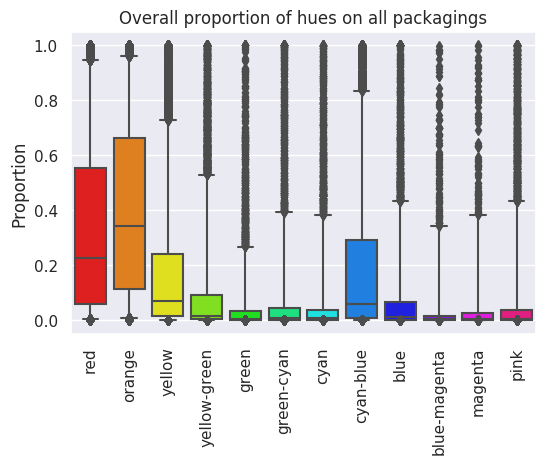

In [14]:
# weird memory leaks otherwize when using divide
colors_prop = colors_only.replace(0, np.nan)
for col in HUES_STR:
    colors_prop[col] /= colors.total_valid_pix

g = sns.boxplot(data=colors_prop, palette=HUES_RGB, whis=[5, 95])
g.set_xticklabels(g.get_xticklabels(), rotation=90)

plot_settings({
    'title': 'Overall proportion of hues on all packagings',
    'ylabel': 'Proportion'})

That being said, we are now interested in looking in the ties between the packagings colour and the products themselves.

## RQ | Colors and nutrition scores

For all the aspects of this second research question, we will focus on the following nutrition facts associated with each product. Besides, we will investigate any trends associated with a product category as given by the attribute `main_category_en`.

In [15]:
NUTRI_COLS

['energy_100g',
 'fat_100g',
 'saturated-fat_100g',
 'carbohydrates_100g',
 'sugars_100g',
 'proteins_100g',
 'salt_100g',
 'sodium_100g',
 'nutrition-score-fr_100g']

In [16]:
data = load_clean_rel_to_nutri(
    usecols=['code', 'main_category_en']+NUTRI_COLS,
    filter_has_image=True)
data.head()

,code,main_category_en,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g
292,0000007020254,Beverages,213.0,0.0,0.0,14.0,0.0,0.0,1.000000,0.393701,12.0
411,0000027533024,Desserts,1284.0,7.0,3.6,54.2,44.0,3.9,0.200000,0.078740,11.0
412,0000027533048,Sugary snacks,1284.0,7.0,3.6,54.2,44.0,3.9,0.199898,0.078700,10.0
427,0000040608754,Beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.025400,0.010000,13.0
531,0000087177756,Beverages,177.0,0.0,0.0,10.4,10.4,0.0,0.100000,0.039370,13.0


To ease the following investigation process we choose to consider a new feature space consisting of $1$ and $0$ for each hue: those numbers correspond to whether or not a hue is present on packaging. Having in mind the need for a minimum of robustness in our findings, we decided to apply a threshold: we will consider that a colour (i.e. hue) is present on a packaging if it represents at least $20\%$ of the total valid pixels (i.e. pixels that are not too dark).

The feature space transformation can be seen below.

In [17]:
colors = get_colors_df()
for col in HUES_STR:
    colors[col] = (colors[col] > 0.2 * colors['total_valid_pix']) * 1
colors.head()

,code,total_pix,total_valid_pix,red,orange,yellow,yellow-green,green,green-cyan,cyan,cyan-blue,blue,blue-magenta,magenta,pink
0,0000007020254,30000,611,1,1,0,0,0,0,0,0,0,0,0,0
1,0000027533024,26800,929,1,1,0,0,0,0,0,0,0,0,0,0
2,0000027533048,28200,153,1,1,0,0,0,0,0,0,0,0,0,0
3,0000040608754,20200,6955,1,0,0,0,0,0,0,1,0,0,0,0
4,0000087177756,20000,1445,0,0,1,0,0,0,0,0,0,0,0,0


Using this new feature space, we can for example see that *red* is present on $46.6 \%$ of the packagings, etc.
Here, we observe here similar trends as the ones we depicted in the previous part.

In [18]:
colors[HUES_STR].mean().round(3) * 100

red             46.6
orange          60.0
yellow          22.0
yellow-green     6.2
green            1.4
green-cyan       1.7
cyan             1.9
cyan-blue       12.8
blue             2.7
blue-magenta     0.3
magenta          0.4
pink             3.5
dtype: float64

This transformation being done, we can merge the dataframe containing the colours and the one with the products information.

In [19]:
merged = colors.merge(data, on='code')

Having this new combined dataset, we can perform several analyses.

### General inspection

First, let's look at the distribution of each nutrition fact for each hue using two visual methods: the *kernel density estimate* of the distribution and the *experimental cumulative distribution function*.

It's important to say that those distributions are, by construction, not independent since a product may be taken into account for several curves. But still we can observe some interesting trends.

On the two series of plots below:

* We can observe some general trends for all hues: the curve associated with all products is often fairly close to the curves associated with each hue.
* Still there are some *outliers hues* that are very specific:
    * *Blue-magenta* and *magenta* appear to be associated with different trends. Often they seem to be a synonym to *worse* nutrition quality: they are associated with products that have more sugar, fat, and a worse overall nutritional rating.
    
    * When looking at the CDFs, we see that the curves associated with the greenish hues are often *above* the ones concerning the other hues: products that have green on their package are more likely to be healthier products with less fat, less sugar, better nutri-scores. 

In [20]:
def nutri_fact_vs_color(nutri_fact):
    """
    Plots the KDE for each hue relative a nutri fact
    """
    for hue_str, hue_rgb in zip(HUES_STR, HUES_RGB):
        sns.kdeplot(merged[merged[hue_str] == 1]
                    [nutri_fact], label=hue_str, color=hue_rgb)

    sns.kdeplot(merged[nutri_fact], label='all', color='black')
    plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    plot_settings({
        'title': "KDE estimation of the distribution of the {} values \n"
                 "for each hue".format(nutri_fact),
        'xlabel': "{} values".format(nutri_fact)})
    plt.show()

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



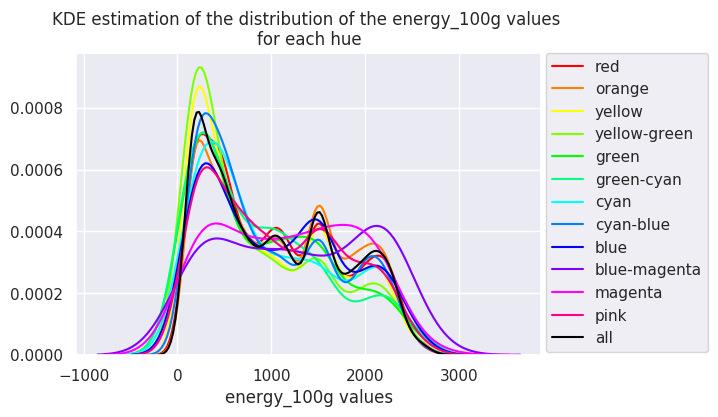

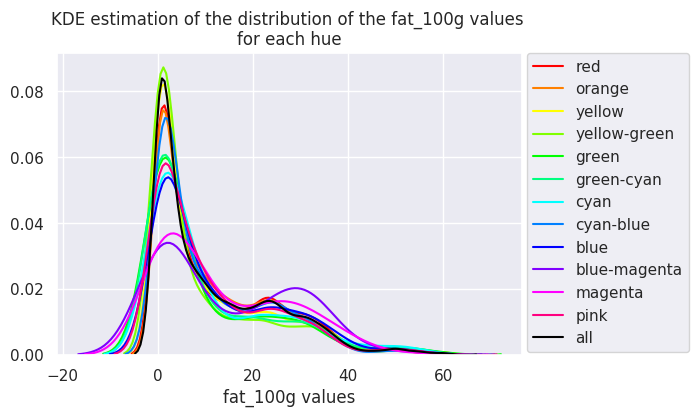

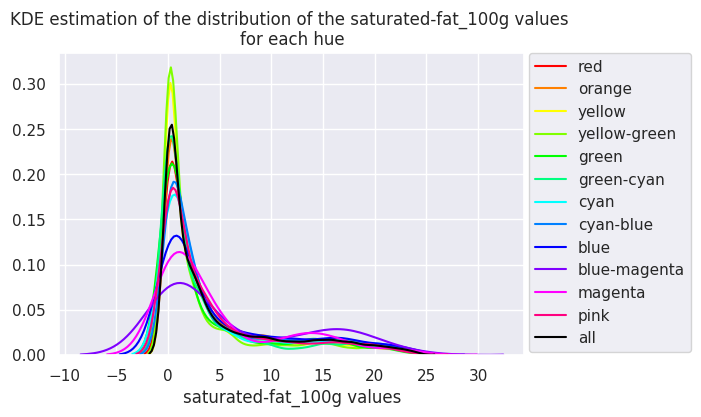

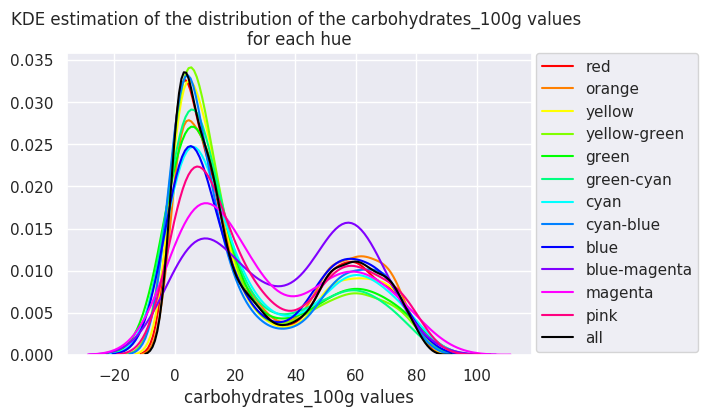

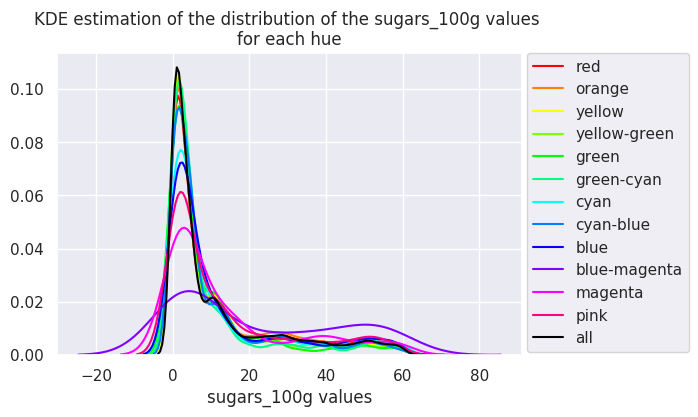

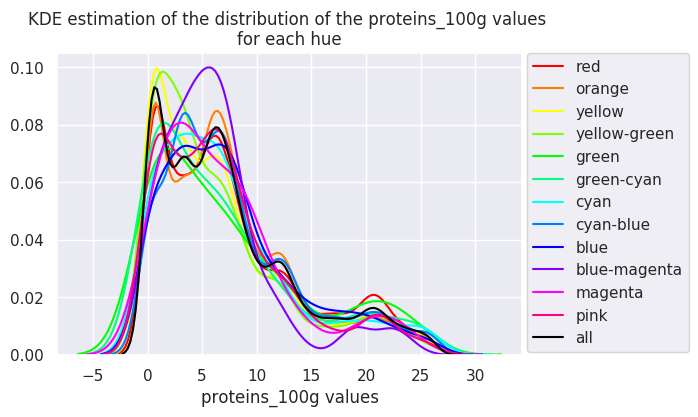

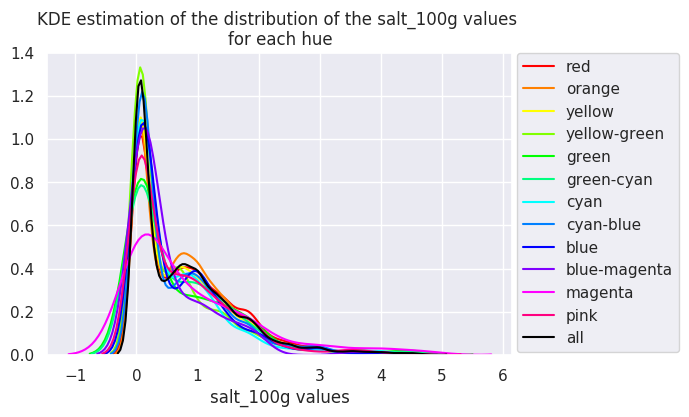

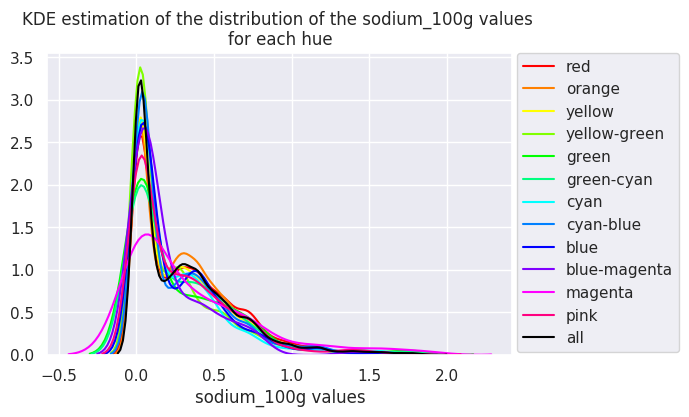

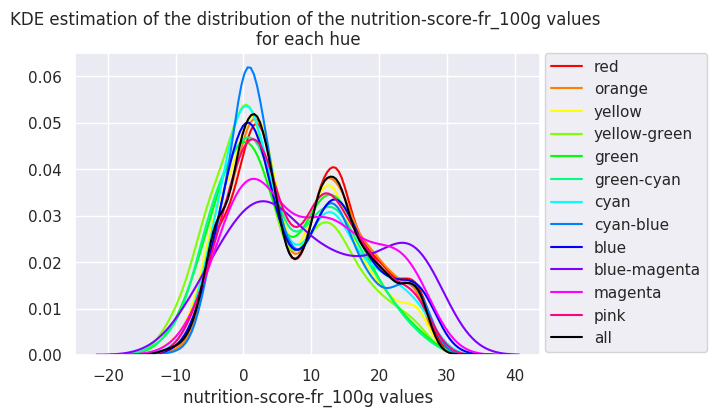

In [21]:
for col in NUTRI_COLS:
    nutri_fact_vs_color(col)

In [22]:
# Handle the export for the data story simultaneaously
def nutri_fact_cdf_vs_color(nutri_fact):

    Q = np.linspace(0, 1, 300)

    # for plotly
    # Use interpolation to have similar x
    d = []
    m = merged[nutri_fact].min()
    M = merged[nutri_fact].max()
    x = np.linspace(m, M, 100)

    for hue_str, hue_rgb in zip(HUES_STR, HUES_RGB):
        qs = merged[merged[hue_str] == 1][nutri_fact].quantile(Q)
        sns.lineplot(qs, qs.index, label=hue_str, color=hue_rgb)
        plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
        plot_settings({
            'title': "CDF of the distribution of the {} values \n"
                     "for each hue".format(nutri_fact),
            'xlabel': nutri_fact})

        # plotly
        d.append(go.Scatter(
            x=x,
            y=np.interp(x, qs, qs.index),
            text='',
            name=hue_str,
            line=dict(color=to_plotly_col(hue_rgb))
        ))

    # Default plot
    plt.show()

    # Plotly
    layout = get_plotly_layout(
        title='Cumulative Density Function (CDF) of the {}'.format(nutri_fact),
        xlabel='$x = \\text{' + nutri_fact + '}$',
        ylabel='$F(x) = \\text{P}(X \\leq x) $'
    )

    fig = go.Figure(data=d, layout=layout)

    plotly_plot(fig, join(EXPORT_FOLDER, 'CDF_{}.html'.format(nutri_fact)))

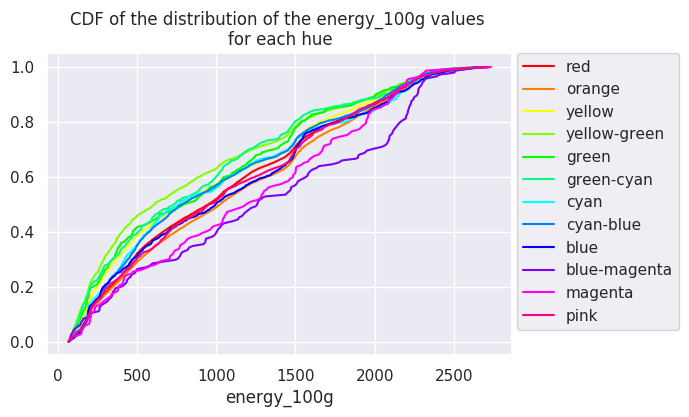

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



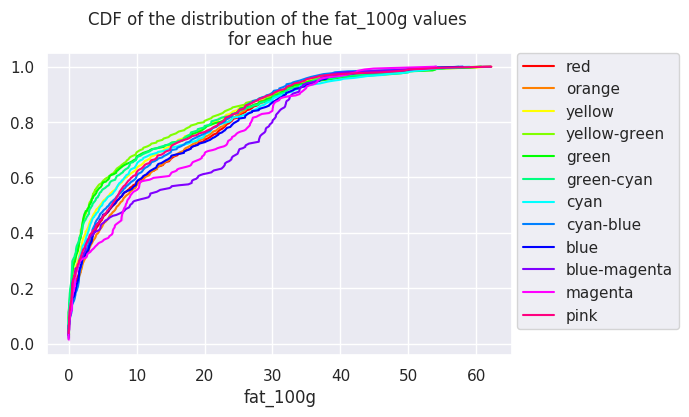

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



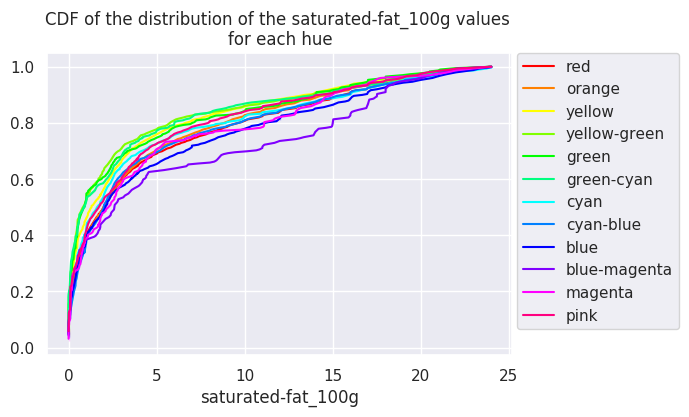

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



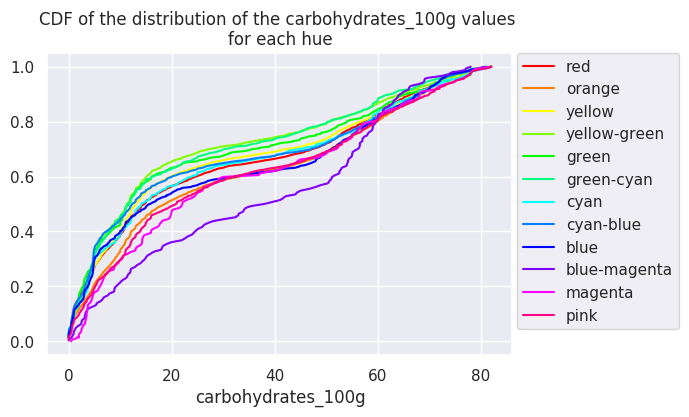

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



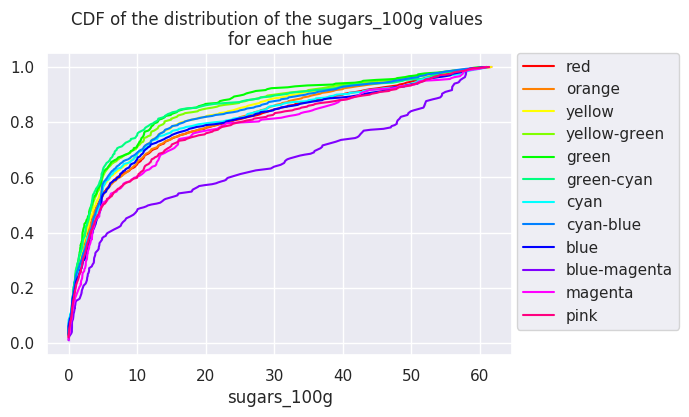

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



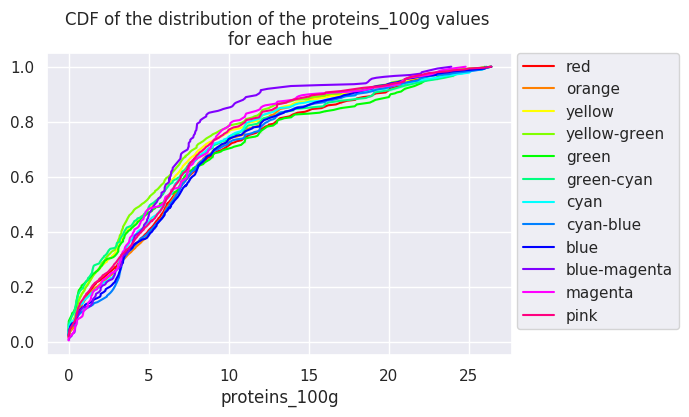

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



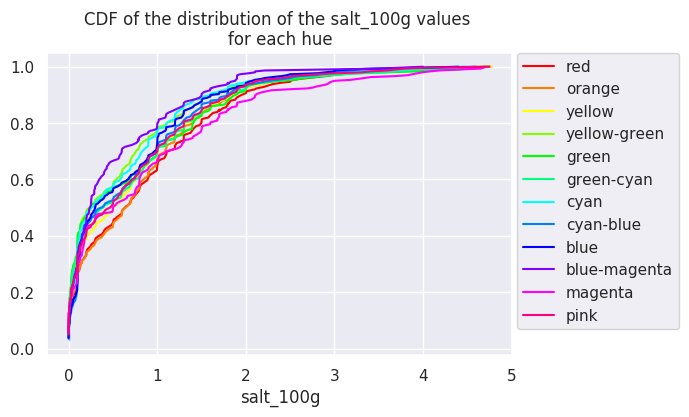

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



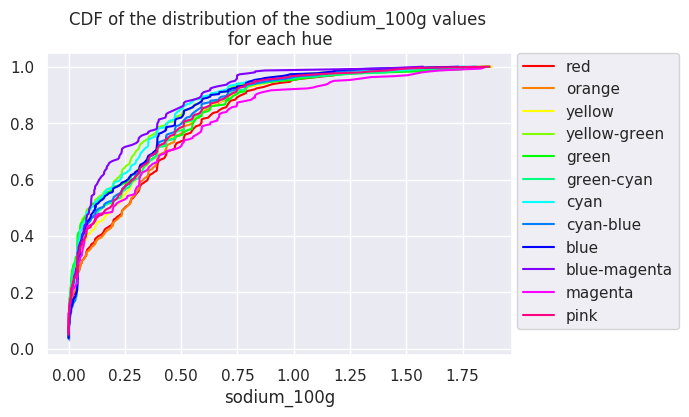

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



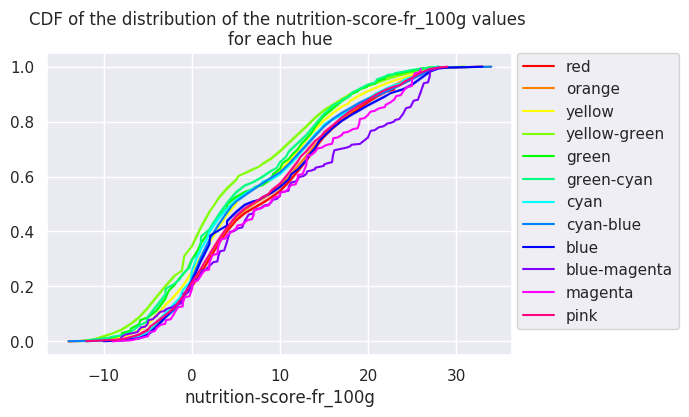

In [23]:
for col in NUTRI_COLS:
    nutri_fact_cdf_vs_color(col)

### Category-wise results

In the previous subsection, we have seen that if  some hues are present on a product packaging then we can expect the product to have some nutritional properties.

Having this said, we would be interested about another tie between hues and products: are there trends when aggregating products at the category level?

To conduct a meaningful analysis we focused on product categories (given by *Open Food Facts*) that have enough products (considering all the steps we have gone through up until now).

As we can see below, we decided to keep the 14 most frequent categories and they all have more than 400 products. We also dropped the `Plant-based foods and beverages` category since our early exploration have shown that this category is the default one and is definitely not a homogenous category.

In [24]:
top_cats = merged.main_category_en \
    .value_counts().head(15)
top_cats = top_cats.drop('Plant-based foods and beverages')
top_cats

Sugary snacks    6448
Dairies          4877
Meats            2736
Meals            2348
Beverages        2334
Groceries        1922
Canned foods     1209
Fruit juices     1136
Frozen foods     1130
Salty snacks     1063
Seafood           873
Desserts          752
Spreads           589
Sandwiches        443
Name: main_category_en, dtype: int64

Then, for each of the above category we can look at the frequency of each hue (i.e. for each category, what is the observed probability of having a specific hue on the packaging of a product that falls into that category).

As we can see below, there are some very clear trends. Among them we can see that:

* *Red* is more frequent on products associated with meat,
* *Greenish* hues are quite frequent on beverages compared to other categories,
* *Blueish* hues are mostly associated with seafood and dairies (~milk) products. 
* Concerning *blue-magenta* we can see that this colour is mostly present on desserts and sugary snacks which can explain the observation we made in the previous subsection.

In [25]:
# A little bit of bootstrap to get confidence interval
# Especially usefull as i => 12


def bootstrap_color_freq(df: pd.DataFrame, hue_str: str) -> dict:
    out = {cat: list() for cat in top_cats.index}

    for n in range(N_BOOTSTRAP):
        sample = df.sample(frac=1, replace=True)
        tmp = sample[['main_category_en', hue_str]] \
            .groupby(by='main_category_en').mean()
        tmp = tmp.reset_index().set_index('main_category_en')
        tmp = tmp[hue_str]
        for cat in out.keys():
            out[cat].append(tmp[cat])

    return pd.DataFrame.from_dict(out)


def plot_bars_hues_cat(df: pd.DataFrame, hue_str: str, hue_rgb: tuple):
    values = bootstrap_color_freq(df, hue_str)
    medians = values.median()
    yerr = values.quantile([0.025, 0.975]) - medians

    medians.plot.bar(
        yerr=yerr.values,
        color=hue_rgb)

    plot_settings({
        'title': 'Frequency of {} in each product category'.format(hue_str),
        'ylabel': 'Hue frequency \n'
                  '(error bars are 95% bootstrapped confidence intervals)'})
    plt.show()

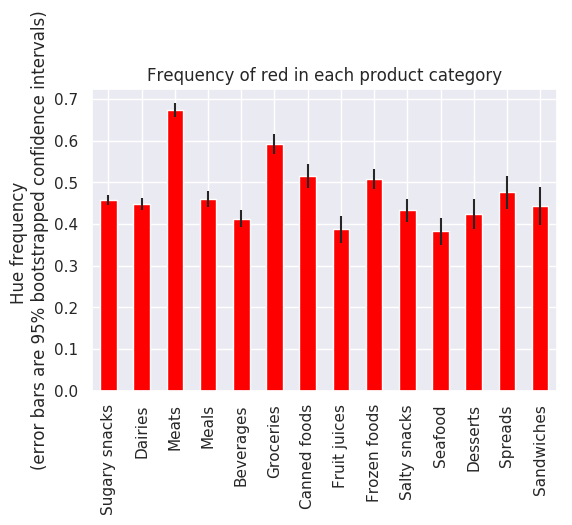

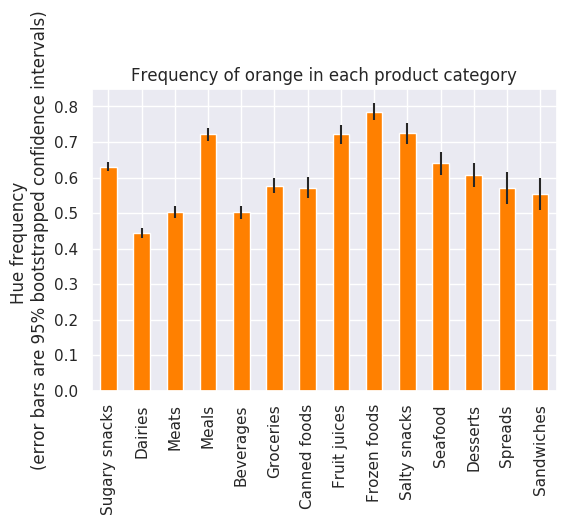

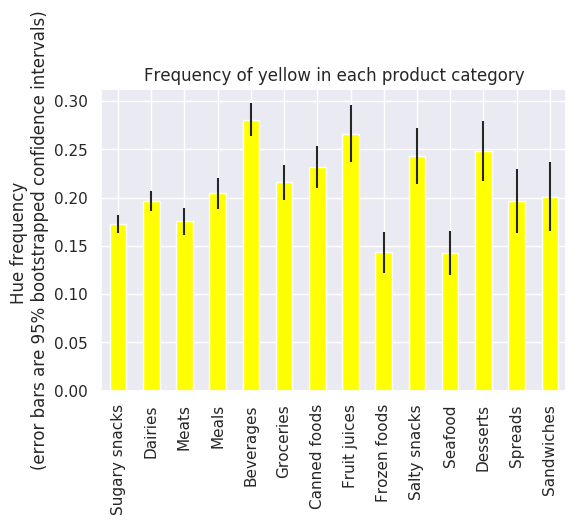

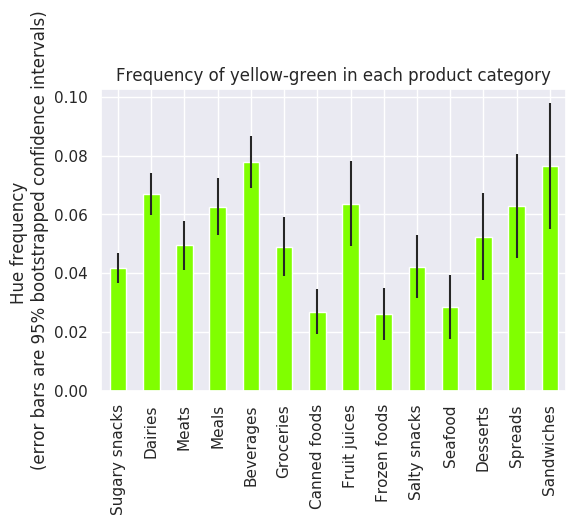

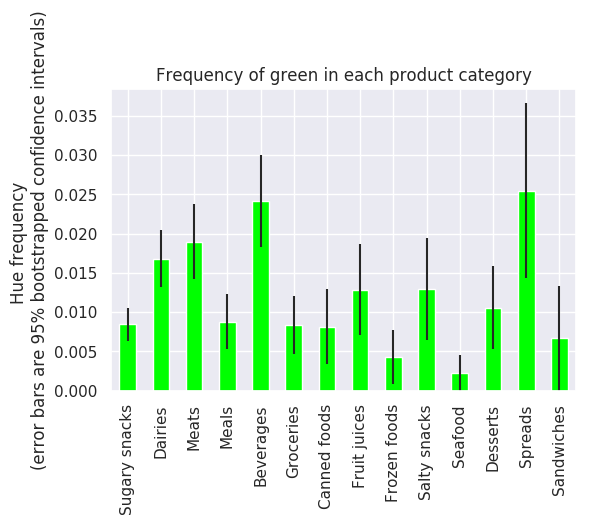

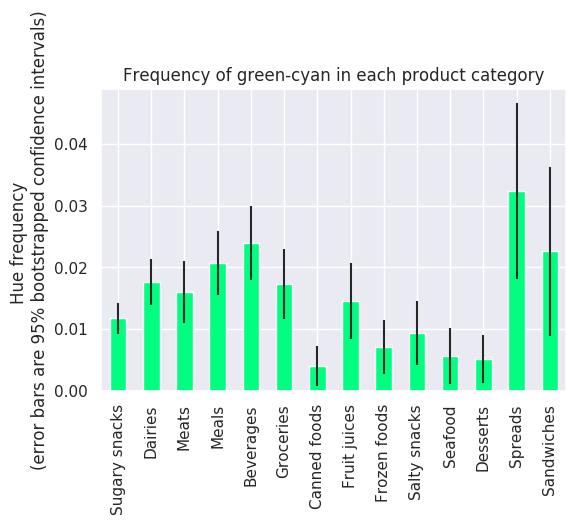

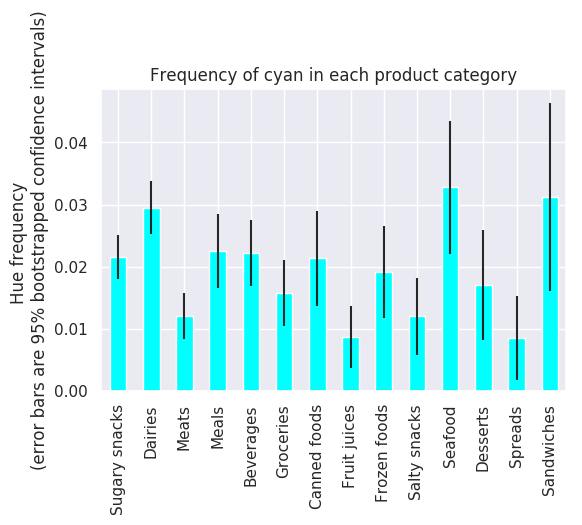

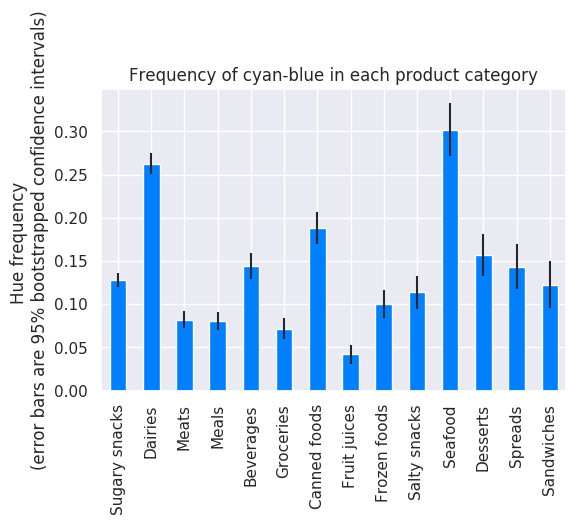

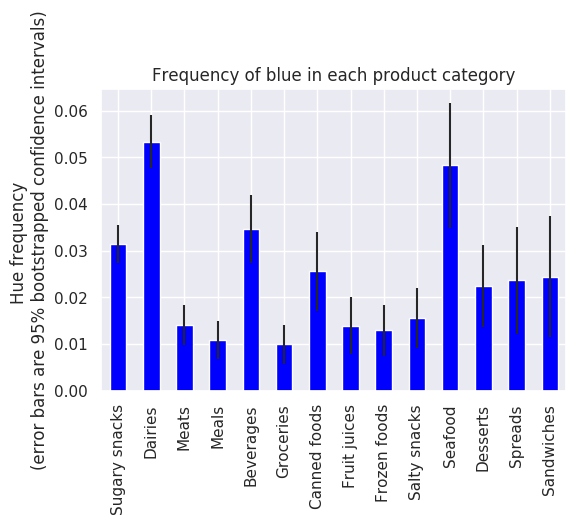

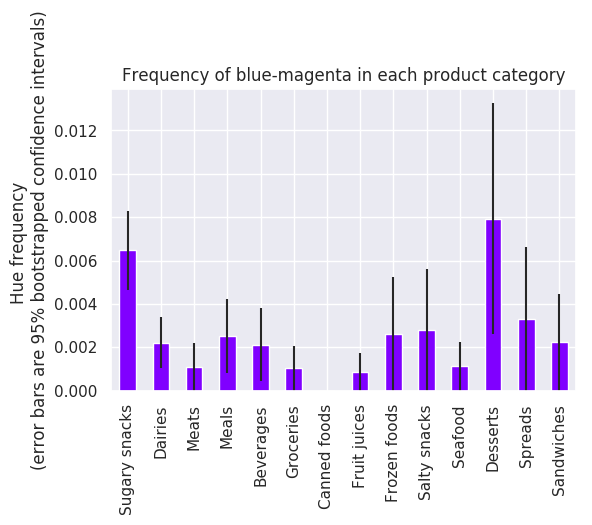

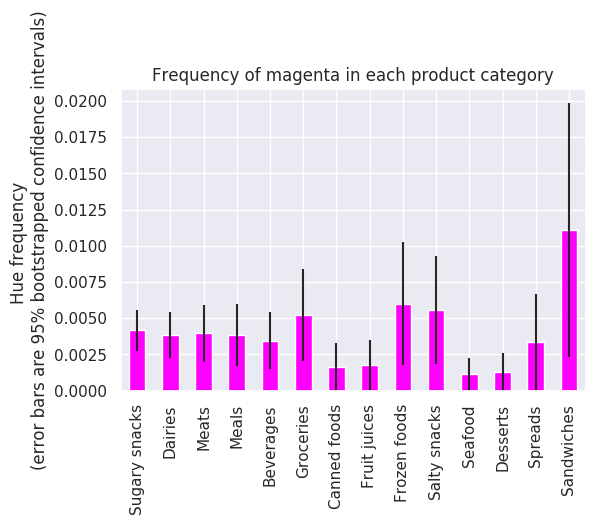

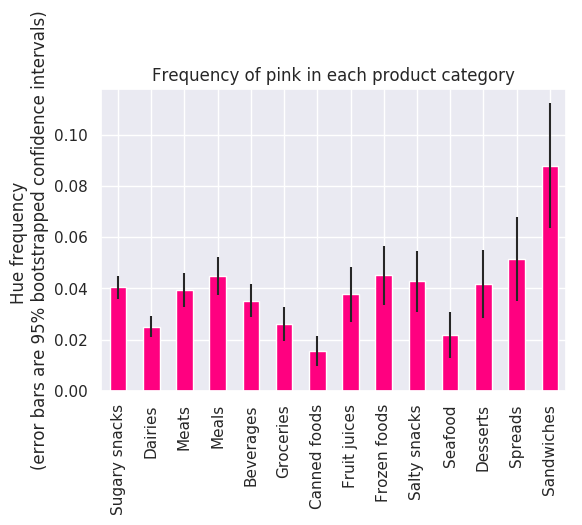

In [26]:
df = merged[merged.main_category_en.isin(top_cats.index)]
for hue_str, hue_rgb in zip(HUES_STR, HUES_RGB):
    plot_bars_hues_cat(df, hue_str, hue_rgb)

In [27]:
# Export for data story
# Similar scripting as above.

for hue_str, hue_rgb in zip(HUES_STR, HUES_RGB):
    values = bootstrap_color_freq(df, hue_str) * 100
    medians = values.median().round(2)
    yerr = values.quantile([0.025, 0.975]).round(2)

    d = [go.Bar(
        x=medians.index.values,
        y=medians.values,
        error_y=dict(
            array=(yerr.iloc[1, :] - medians).abs().values,
            arrayminus=(yerr.iloc[0, :] - medians).abs().values,
            type='data',
            symmetric=False,
            color='rgb(30,30,30)'
        ),
        marker=dict(color=to_plotly_col(hue_rgb))
    )]

    layout = get_plotly_layout(
        title='Frequency of <i>{}</i> in each product category'.format(
            hue_str),
        xlabel='Categories',
        ylabel='$\\text{Hue frequency in} \%$')

    fig = go.Figure(data=d, layout=layout)

    plotly_plot(fig, join(EXPORT_FOLDER, 'cat_{}.html'.format(hue_str)))

### Green vs the rest of the world

Finally, we are interested specifically about the colour *green* and the following question: can we observe any proof of *greenwashing* in the data?

To do so, we select all the products that have either *yellow-green*, *green* or *green-cyan* on their packaging as the most dominant colour.

In [28]:
# first, we add the code column
colors_ranks['code'] = colors['code']

merged_rank = colors_ranks.merge(data, on='code')
mask_green = (merged_rank['yellow-green'] == 1) | \
             (merged_rank['green'] == 1) | \
             (merged_rank['green-cyan'] == 1)

print("{} products have been identified "
      "with a greenish dominant hue.".format(mask_green.sum()))
print("{} products have been identified with a dominant hue "
      "clearly different from green.".format((~mask_green).sum()))

2138 products have been identified with a greenish dominant hue.
40630 products have been identified with a dominant hue clearly different from green.


If we take a look at the density of the nutrition score for products that have green as their dominant packaging colours vs the others, we can't really see anything interesting: there is no weird shape nor a clear difference between the two.

When we look at the energy, the last bump may look suspicious but this one is also present on the curve for all products that don't have green and is actually bigger.

/home/florentchehab/git/EPFL/ADA/healthy-candies/venv/lib64/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



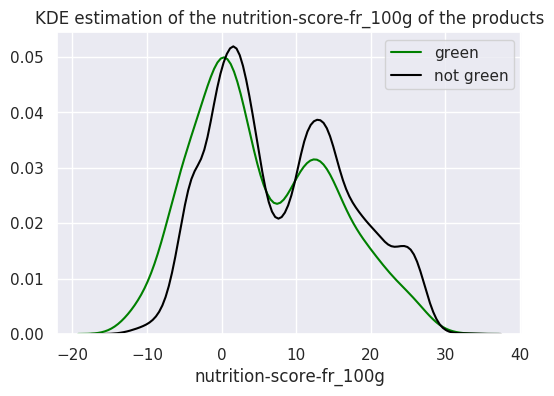

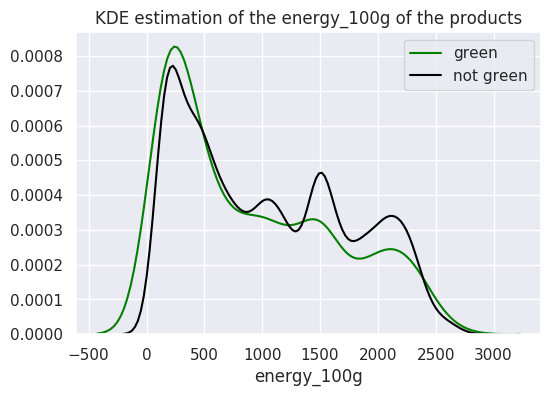

In [29]:
for col in ['nutrition-score-fr_100g', 'energy_100g']:
    sns.kdeplot(merged_rank.loc[mask_green, col], color='green', label='green')
    sns.kdeplot(merged_rank.loc[~mask_green, col],
                color='black', label='not green')
    
    plot_settings({
        'title': 'KDE estimation of the {} of the products'.format(col),
        'xlabel': col})

    plt.show()

In [30]:
# Export for data story


def get_kde(serie: pd.Series, m: float, M: float) -> tuple:
    """
    Return the KDE estimation of a series between m and M
    """
    kernel = gaussian_kde(serie)
    x = np.linspace(m, M, N_KDE_STEPS)
    y = kernel(x)

    return x, y


for col, col_str, label in zip(
    ['nutrition-score-fr_100g', 'energy_100g'],
    ['Nutri-Score', 'Energy for 100g in Kj'],
        ['products Nutri-Score', 'energy contained in 100g of each product']):
    d = []

    green = merged_rank.loc[mask_green, col]
    not_green = merged_rank.loc[~mask_green, col]
    m = merged_rank[col].min()
    M = merged_rank[col].max()

    x, y = get_kde(green, m, M)
    d.append(go.Scatter(
        x=x,
        y=y,
        text='',
        name='Green',
        line=dict(color=to_plotly_col((0, 1, 0)), width=4)
    ))

    x, y = get_kde(not_green, m, M)
    d.append(go.Scatter(
        x=x,
        y=y,
        text='',
        name='Other hues combined',
        line=dict(color='black', dash='dash')
    ))

    layout = get_plotly_layout(
        title='Gaussian KDE estimation of the ' + label,
        xlabel=col_str
    )
    fig = go.Figure(data=d, layout=layout)

    plotly_plot(fig, join(EXPORT_FOLDER, 'green_vs_all_KDE_{}.html'.format(col)))

From this point of view we can't really say that there are some missus of green on product packagings. At the end, it is very hard to identify this behaviour and therefore to quantify it.

One thing is sure, there are some products that have very bad nutritional properties and that use *green* for commercial purposes. Here are some example we (very quickly) found in the *tail* of the energy of products with green:

- Some chocolate: $2 \, 330$ Kj / 100g & E Nutri-score

![](https://static.openfoodfacts.org/images/products/20000233/front_de.44.400.jpg)

- Some Chorizo: $1 \, 900$ Kj / 100g & E Nutri-score

![](https://static.openfoodfacts.org/images/products/26013077/front_fr.22.full.jpg)

- Some chips: $1 \, 818$ Kj / 100g & D Nutri-score

![](https://static.openfoodfacts.org/images/products/842/169/184/9969/front_es.6.400.jpg)


It also has to be said that some products have a "bio" label and sometimes for such products the brand would heavily rely on the green aspect to promote it, whereas the product can have extremely bad nutritional characteristics.

For instance, the product below:

-$2 \, 188$ Kj / 100g & E Nutri-score


![](https://static.openfoodfacts.org/images/products/326/385/292/5311/front_fr.7.full.jpg)